In [2]:
import pandas as pd
import mc_processor
import os

In [3]:
## toggle

# survey_year = input("What year is the survey you want to analyze from? (2022, 2023, or 2024)")
survey_year = str(2024)

In [4]:
# read results files
codebook = pd.read_csv(os.path.join(survey_year,'raw/levels_codebook.csv'), encoding='utf-8')
data = pd.read_csv(os.path.join(survey_year,'raw/data.csv'), encoding='utf-8')
q_codebook = pd.read_csv(os.path.join(survey_year,'raw/question_codebook.csv'), encoding='utf-8', index_col = 'qid')

# q_codebook into dict
q_codebook = q_codebook.to_dict().get('qidFull')

In [5]:
nulldata = pd.DataFrame(data.isnull().sum(),columns=["Sum_Null"]) ##2204 rows in 2024
nulldata.sort_values(by=["Sum_Null"],ascending=False,inplace=True)

# nulldata[nulldata["Sum_Null"]>0].head(20)

Use `get_percents` to get percent who selected each option, works for questions that have multiple or single selection.

Demo input optional. For all demo categories, see next cell.

In [6]:
# all demo categories
for key in q_codebook:
    if "dem" in key:
        print(key)

xdemAll
demZIP
xdemGender
demAgeGeneration
xdemIdeo3
xdemInc3
xdemWhite
xdemHispBin
demBlackBin
demRaceOther
xdemReligion
xdemReligOther
xdemEvang
xdemUsr
xdemEmploy
xdemMilHH1
xdemBidenApprove
xdemBidenApprove2
demInsured
demInsType
demUnion
demLGBTQ1
xdemMarried
BPCxdem1
BPCxdem2
BPCxdem3
BPCxdem4
BPCxdem5


In [7]:
## OVERALL CONFIDENCE RATES

demo = None
question_number = 20

for i in range(20,24):
    display(mc_processor.run_confidence(data,codebook,q_codebook,i).map(lambda x: f"{x:.1%}"))

BPC20 How confident are you that your vote in the November 2024 General Election will be counted as you intend?


,overall
Very confident,35.0%
Somewhat confident,29.4%
Don't know/ No opinion,18.1%
Not to confident,9.7%
Not confident at all,7.9%


BPC21 How confident are you that your votes in your county or city will be counted as intendedin the November 2024 General Election?


,overall
Very confident,35.9%
Somewhat confident,28.9%
Don't know/ No opinion,18.1%
Not to confident,9.5%
Not confident at all,7.5%


BPC22 How confident are you that votes in your state will be counted as intended in the November 2024 General Election?


,overall
Very confident,34.8%
Somewhat confident,29.3%
Don't know/ No opinion,17.1%
Not to confident,11.2%
Not confident at all,7.6%


BPC23 How confident are you that votes nationwide will be counted as intended in the November 2024 General Election?


,overall
Very confident,31.1%
Somewhat confident,28.1%
Don't know/ No opinion,17.5%
Not to confident,13.8%
Not confident at all,9.5%


In [8]:
## TO ASK FOR CONFIDENCE QUESTIONS

#split sample a - regular order
#split sample b - reverse order
#split sample c - random order

all_dfs = []

for i in range(20,24):
    # store dfs for each sample
    q_dfs = []    
    for split_sample in ["a","b","c"]:
        question = "BPC"+str(i)+split_sample
    
        # get results for question by sample
        df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo=None,suppress_output=True)
        df.columns = [f"split sample {split_sample}"]
        q_dfs.append(df)
    
    print(q_codebook[question]) # defaults to split sample c, but tested with other a/b/c combos and got same result (they rotated question order but didn't change question #)
    
    q_df = pd.concat(q_dfs, axis=1)

    q_df["deviation"] = q_df.std(axis=1)

    # format first three q_df columns as percent
    q_df.iloc[:,0:3] = q_df.iloc[:,0:3].map(lambda x: f"{x:.1%}")

    display(q_df)

    all_dfs.append(q_df)


How confident are you that your vote in the November 2024 General Election will be counted as you intend?


,split sample a,split sample b,split sample c,deviation
Very confident,38.5%,33.9%,32.5%,0.031315
Somewhat confident,28.8%,29.8%,29.5%,0.005236
Don't know/ No opinion,17.8%,16.9%,19.4%,0.012672
Not to confident,8.5%,10.3%,10.4%,0.010620
Not confident at all,6.4%,9.1%,8.2%,0.013669


How confident are you that your votes in your county or city will be counted as intendedin the November 2024 General Election?


,split sample a,split sample b,split sample c,deviation
Very confident,38.1%,35.7%,33.9%,0.021075
Somewhat confident,27.8%,30.5%,28.7%,0.014024
Don't know/ No opinion,18.7%,16.9%,18.7%,0.010562
Not to confident,8.9%,9.2%,10.5%,0.008471
Not confident at all,6.5%,7.7%,8.2%,0.008393


How confident are you that votes in your state will be counted as intended in the November 2024 General Election?


,split sample a,split sample b,split sample c,deviation
Very confident,36.7%,35.4%,32.3%,0.022684
Somewhat confident,30.0%,27.0%,30.7%,0.019479
Don't know/ No opinion,17.5%,15.9%,17.7%,0.009870
Not to confident,9.5%,12.4%,11.9%,0.015476
Not confident at all,6.3%,9.2%,7.5%,0.014706


How confident are you that votes nationwide will be counted as intended in the November 2024 General Election?


,split sample a,split sample b,split sample c,deviation
Very confident,32.1%,33.0%,28.3%,0.024627
Somewhat confident,28.0%,26.3%,29.9%,0.017734
Don't know/ No opinion,18.2%,16.4%,18.0%,0.009440
Not to confident,12.8%,14.3%,14.3%,0.008447
Not confident at all,8.9%,10.0%,9.6%,0.005307


<Axes: >

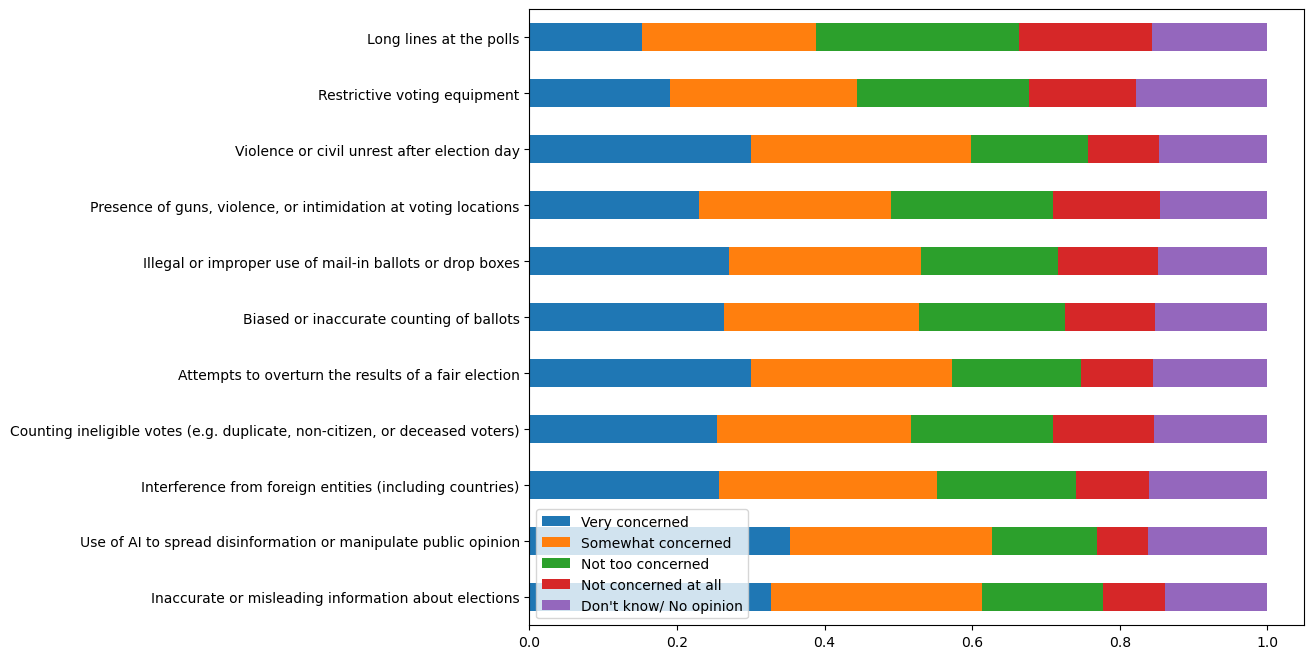

In [16]:
df.plot(kind='barh', stacked=True, figsize=(10, 8))



BPC1: How often do you seek out the following kinds of information about elections, if at all? 


,"Only around major election dates or deadlines (e.g. Voter registration deadlines, Election Day)",A few times in the weeks around major election dates or deadlines,Regularly in the weeks around major election dates or deadlines,Consistently throughout the year,Never
Information about how to register and vote,23%,13%,14%,12%,39%
Information about how elections are run,20%,16%,15%,13%,36%
Information about who won an election,30%,13%,19%,14%,23%
Information about candidates,18%,18%,20%,22%,23%
News about campaigns,16%,18%,20%,19%,27%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC2: Below is a list of sources from which people might get news and information about elections. After reading this list of sources, please choose the three that you use most often to learn about elections. 


,overall
Social media,39%
National television,36%
Local or regional television,28%
Search through Google or other search engines,23%
"National news outlets, print or online",22%
"Local or state news outlets, print or online",19%
Radio,16%
Podcasts,10%
I am not interested in election news or information,8%
"News aggregator apps (e.g. NewsBreak, Smart News, Apple News)",8%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC3: If you wanted to know more about how elections are run in the United States, where are you most likely look for that information? Please select up to three. 


,overall
"News media professionals (local/national TV news anchors, journalists, reporters)",27%
Friends and family,24%
A federal agency or website dedicated to elections (e.g. the U.S. Election Assistance Commission or vote.gov),21%
Don't know/ No opinion,17%
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",14%
Election-related organizations (including integrity and voting rights groups),14%
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",13%
"Your favorite commentator or analyst from a radio show, podcast, TV show, blog, or newspaper",13%
Local or county administrators,12%
State election administrators,12%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC4: 'If you wanted to know more about how elections are run in the United States, where would you be most likely look for that information? Please select up to three.' 


,overall
A federal agency or website dedicated to elections (e.g. the U.S. Election Assistance Commission or vote.gov),27%
"News media professionals (local/national TV news anchors, journalists, reporters)",21%
Friends and family,21%
Election-related organizations (including integrity and voting rights groups),18%
Don't know/ No opinion,18%
State election administrators,16%
Local or county administrators,13%
"Your favorite commentator or analyst from a radio show, podcast, TV show, blog, or newspaper",12%
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",12%
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",10%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC5: If you are interested in learning about the winner of an election, where would you be most likely to look for results? Please select up to three. 


,overall
"News media professionals (local/national TV news anchors, journalists, reporters)",39%
Friends and family,20%
A federal agency or website dedicated to elections (e.g. the U.S. Election Assistance Commission or vote.gov),17%
"Your favorite commentator or analyst from a radio show, podcast, TV show, blog, or newspaper",16%
Don't know/ No opinion,15%
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",13%
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",11%
State election administrators,11%
Election-related organizations (including integrity and voting rights groups),11%
Your preferred candidate,10%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC6: Which of the following online platforms would you most likely look to for election news and information, if any? Please select up to three answers. 


,overall
Google,45%
YouTube,37%
Facebook,34%
TikTok,15%
Instagram,15%
Twitter/X,13%
I do not consume information about elections online,11%
Don't know/ No opinion,7%
Reddit,4%
Snapchat,3%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC7: Specifically thinking about the information you need to register and vote, which of the following online platforms, if any, are you most likely to use? Please select up to three answers. 


,overall
Google,45%
YouTube,24%
Facebook,24%
I do not consume information about elections online,14%
Don't know/ No opinion,13%
Instagram,10%
TikTok,9%
Twitter/X,9%
Reddit,4%
"Other, please specify",4%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC8: What are the primary ways you engage with content related to elections on online platforms? Please select up to three answers. 


,overall
Browsing or reading posts about election-related topics,37%
Clicking on links to learn more about election topics,26%
"None of the above, I do not engage with election content on online platforms",24%
Sharing content offline with your friends/family,18%
Commenting on or discussing election-related posts,15%
Liking or reacting to election-related posts,14%
"Privately sharing election content (e.g. through private messages, direct messages)",12%
Don't know/ No opinion,12%
Sharing election content with your followers,9%
Creating and posting your own election-related content,8%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC9: How frequently do you engage in political discussions or share political content in messaging platforms like WhatsApp, Discord, iMessage, or similar apps?


,overall
Not at all,29%
Never,20%
Rarely,20%
Weekly,14%
Daily,10%
Monthly,7%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC10: What is the nature of your participation in political groups or chat communities within messaging platforms?


,overall
I mostly observe discussions had by others,57%
I participate occasionally,23%
I participate regularly and actively contribute to discussions,11%
"Other, please describe",10%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC11: How frequently do you think you encounter AI-generated information about elections?


,overall
Don't know/ No opinion,31%
Never,19%
Daily,16%
Weekly,14%
Rarely,13%
Monthly,6%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC12: How frequently do you choose to use AI tools (like ChatGPT, Gemini, or Claude) to ask questions about elections or get information about elections?


,overall
Never,46%
Don't know/ No opinion,17%
Rarely,16%
Weekly,9%
Daily,7%
Monthly,6%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC13: Do you think you have encountered information about elections that was AI-generated, without knowing it was AI-generated?


,overall
"Yes, probably",36%
Don't know/ No opinion,25%
"Yes, definitely",16%
"No, definitely not",13%
"No, probably not",9%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC14: When it comes to the 2024 presidential election, do you think each of the following would generally be a good thing, a bad thing, or neither a good nor a bad thing? 


,Very good thing,Somewhat good thing,Neither good nor bad thing,Somewhat bad thing,Very bad thing
Voters using AI chatbots to find out information about a candidate or an issue on the ballot,8%,17%,38%,16%,20%
Voters using AI chatbots to find out information about how to cast their ballot,10%,19%,39%,13%,20%
Voters using AI chatbots to find information on how to register to vote,11%,22%,37%,12%,19%
Voters using AI chatbots to decide which candidate to vote for,6%,11%,33%,17%,33%
Voters using AI chatbots to learn about how candidates' positions align with their personal values and priorities,9%,16%,39%,15%,20%
"Political campaigns using AI to create content, including advertisements for voters, without disclosing that AI was used in the process",5%,10%,33%,19%,31%
"Political campaigns using AI to create content, including advertisements for voters, with clear disclosure that AI was used in the process",9%,17%,39%,14%,22%
Candidates using AI to edit or touch-up photos or videos for their political advertisements,6%,12%,38%,18%,26%
Candidates using AI to tailor their political advertisements to individual voters,7%,13%,37%,18%,26%
Candidates using AI chatbots to answer voters' questions about campaigns,7%,15%,35%,18%,25%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC15: How do you generally feel when you see posts about elections online?


,overall
Neutral – I don't have strong feelings either way,28%
"Somewhat positive – I appreciate staying updated, even if it is overwhelming at times",16%
"Somewhat negative – it can be tiresome, but I still pay attention",14%
Very positive – I feel informed and engaged,13%
Don't know/ No opinion,12%
I actively avoid election-related posts on social media,11%
Very negative – I feel overwhelmed and fatigued by the constant stream of information,7%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC16: People use different approaches when consuming information about elections. Which of the following approaches, if any, do you currently use? Please select all that apply. 


,overall
Read sources I believe are accurate,35%
Pay attention to the reputation or credibility of the author or publication,30%
Look for primary sources or official statements,27%
I do not use any of these approaches,27%
Compare information across multiple sources,27%
Verify information by using fact-checking websites,24%
Read information from friends with a variety of viewpoints,17%
Ensure that my social media feed reflects a variety of viewpoints,13%
Consult experts or specialists on the topic,10%
"Other, please specify",0%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC17: Do you believe each of the following are doing too little or too much to protect users from harmful content, if at all? 


,Far too little,Too little,About the right amount,Too much,Far too much,Don't know/ No opinion
Social media platforms,21%,21%,26%,9%,7%,16%
Your state government,14%,23%,33%,7%,5%,19%
Federal government,16%,23%,29%,9%,6%,18%
Local government,12%,22%,34%,7%,5%,20%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC18: Who do you think should be the most responsible for protecting users from false or deceptive election content on social media platforms?


,overall
Social media platforms and government should share the responsibility,33%
Mainly the responsibility of social media platforms,22%
Don't know/ No opinion,20%
Mainly the responsibility of government,14%
Neither are responsible,11%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC19: Do you agree or disagree with the following statement?In the most recent election I voted in, my voting experience was mostly positive.


,overall
Strongly agree,36%
Somewhat agree,29%
Don't know/ No opinion,23%
Somewhat disagree,7%
Strongly disagree,4%


<Axes: xlabel='Response', ylabel='Percentage'>



BPC24: How concerned are you, if at all, about the following when it comes to the 2024 General Election? 


,Very concerned,Somewhat concerned,Not too concerned,Not concerned at all,Don't know/ No opinion
Inaccurate or misleading information about elections,33%,29%,16%,8%,14%
Use of AI to spread disinformation or manipulate public opinion,35%,27%,14%,7%,16%
Interference from foreign entities (including countries),26%,30%,19%,10%,16%
"Counting ineligible votes (e.g. duplicate, non-citizen, or deceased voters)",25%,26%,19%,14%,15%
Attempts to overturn the results of a fair election,30%,27%,17%,10%,16%
Biased or inaccurate counting of ballots,26%,26%,20%,12%,15%
Illegal or improper use of mail-in ballots or drop boxes,27%,26%,18%,14%,15%
"Presence of guns, violence, or intimidation at voting locations",23%,26%,22%,14%,15%
Violence or civil unrest after election day,30%,30%,16%,10%,15%
Restrictive voting equipment,19%,25%,23%,14%,18%


<Axes: xlabel='Response', ylabel='Percentage'>

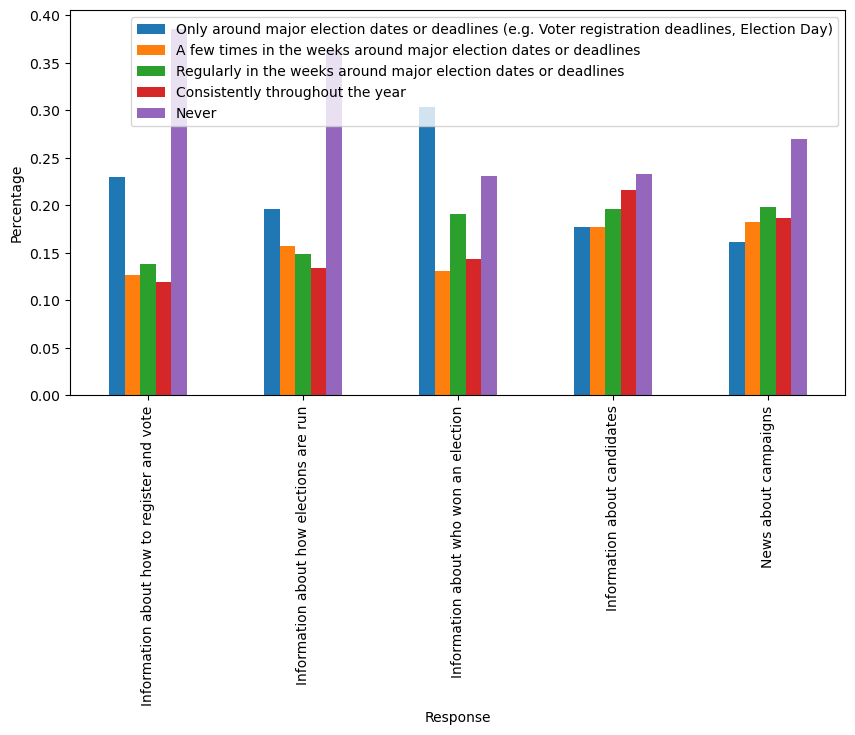

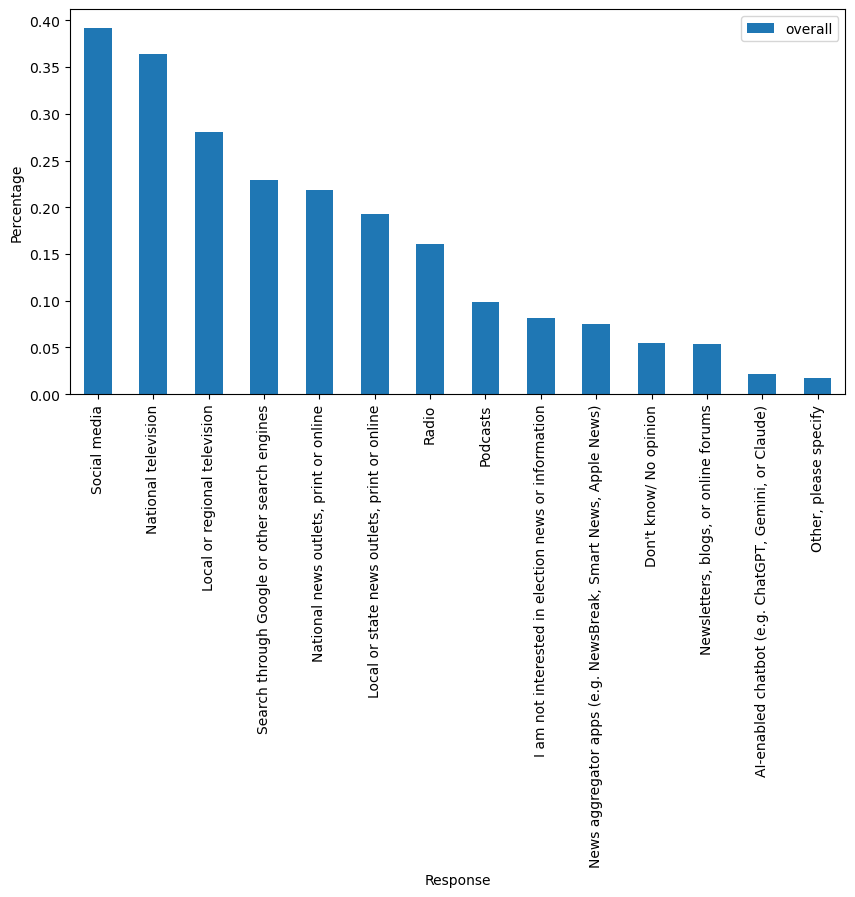

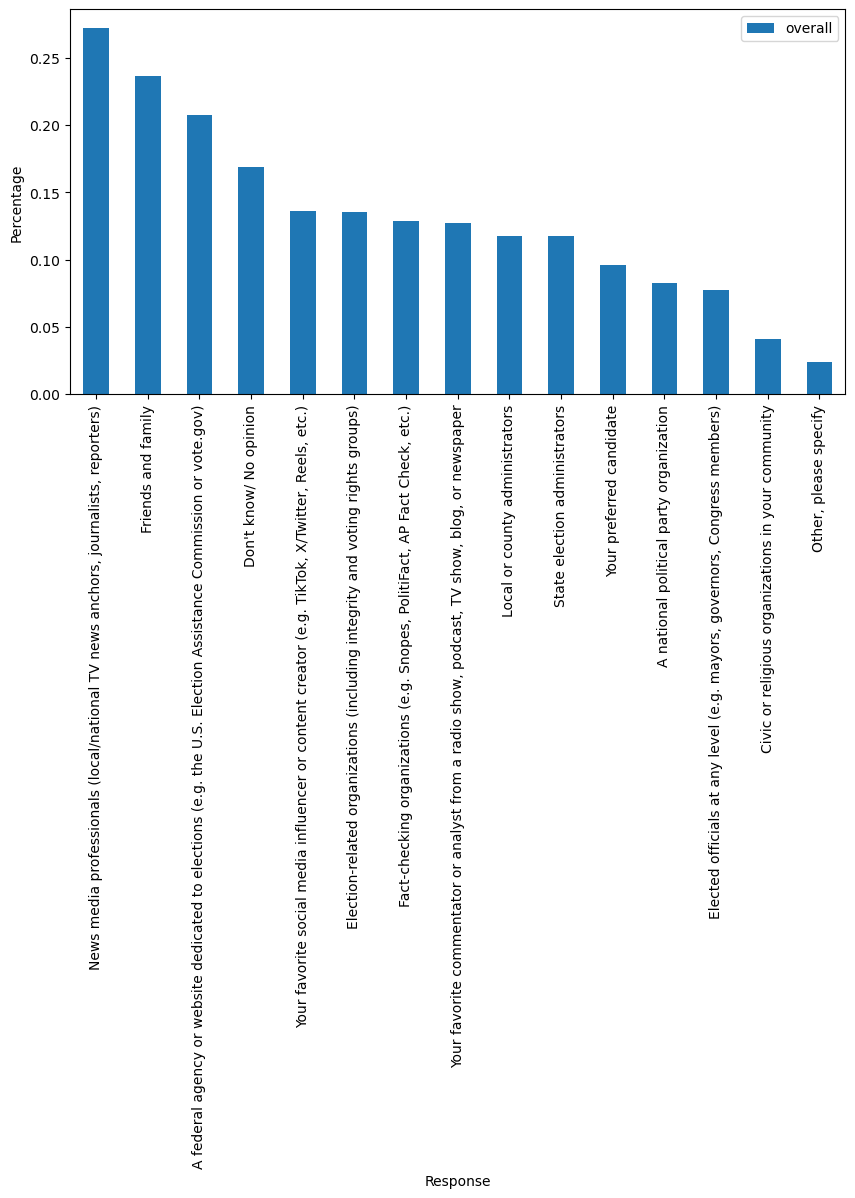

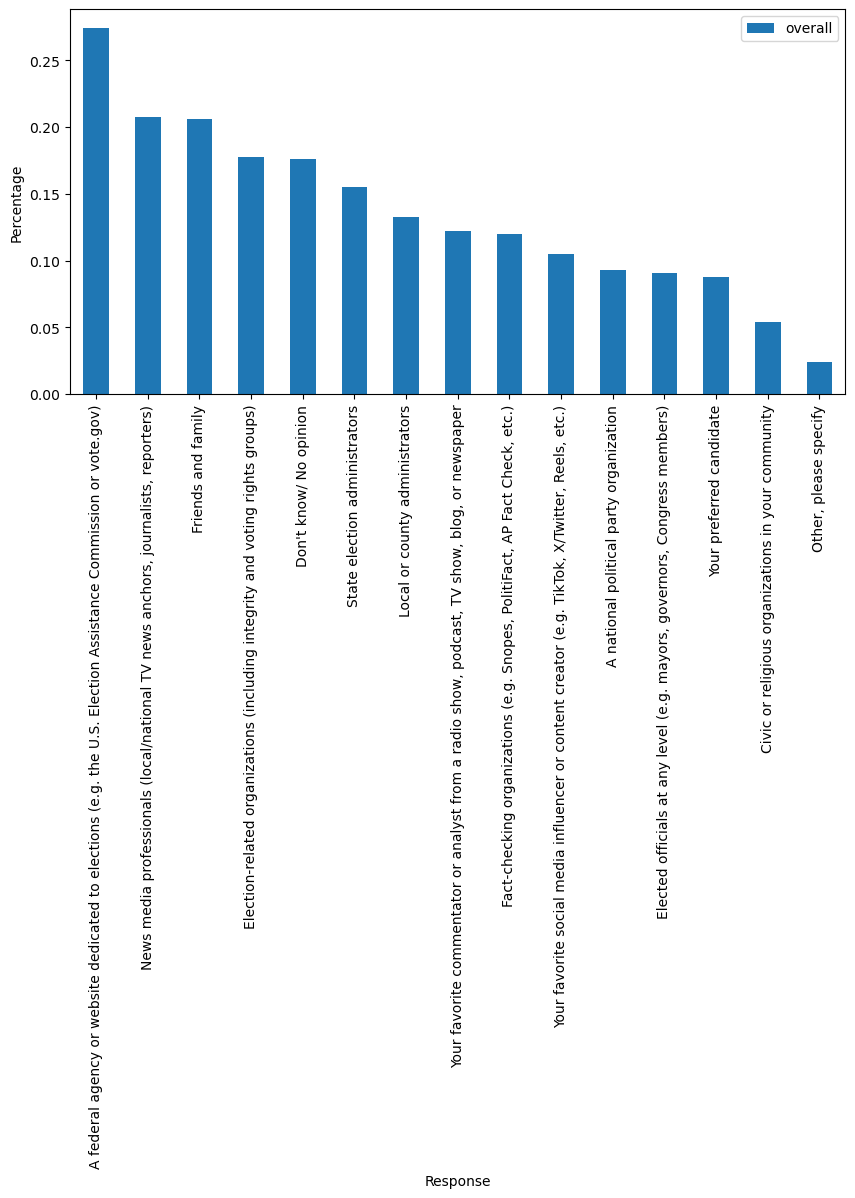

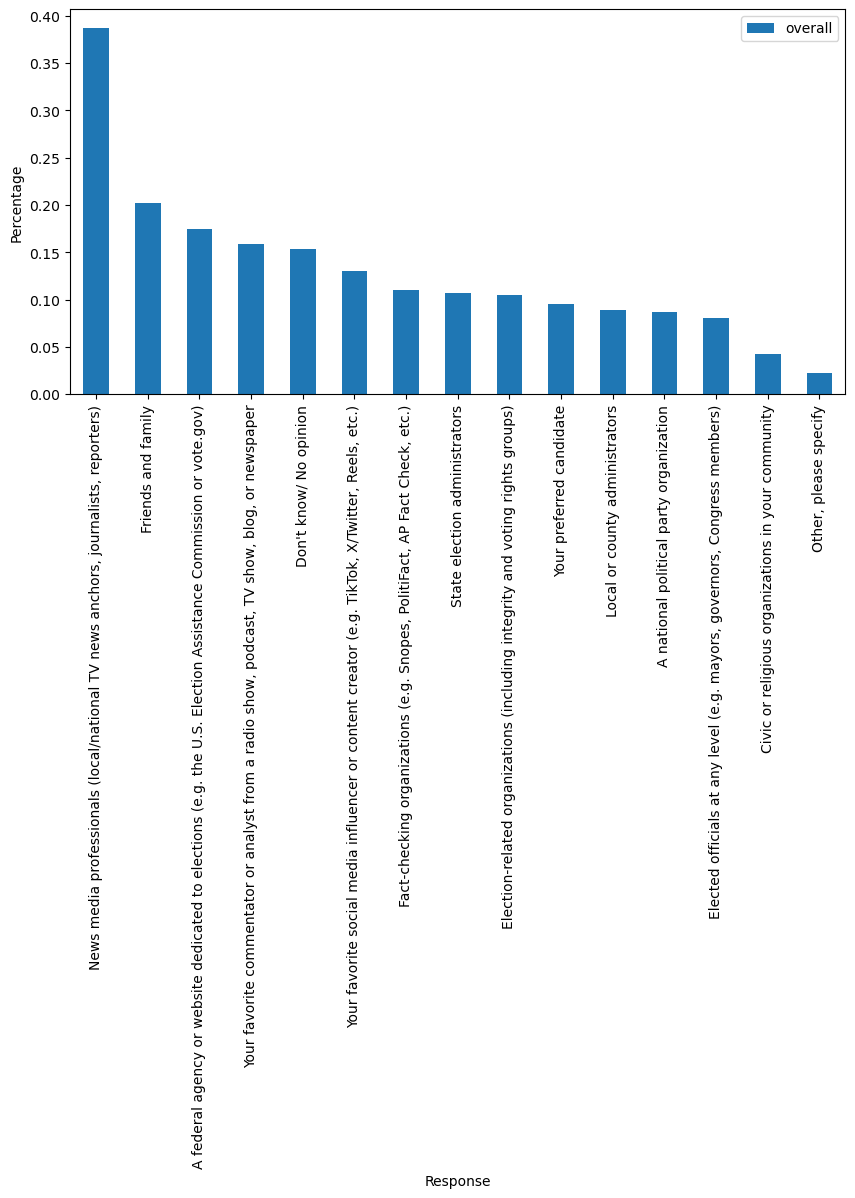

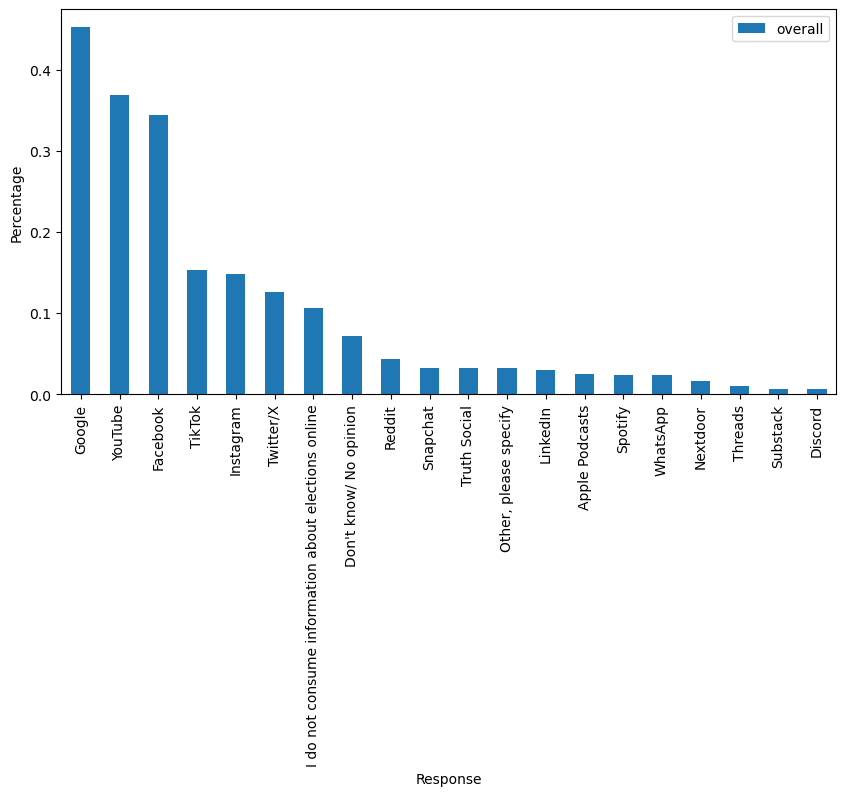

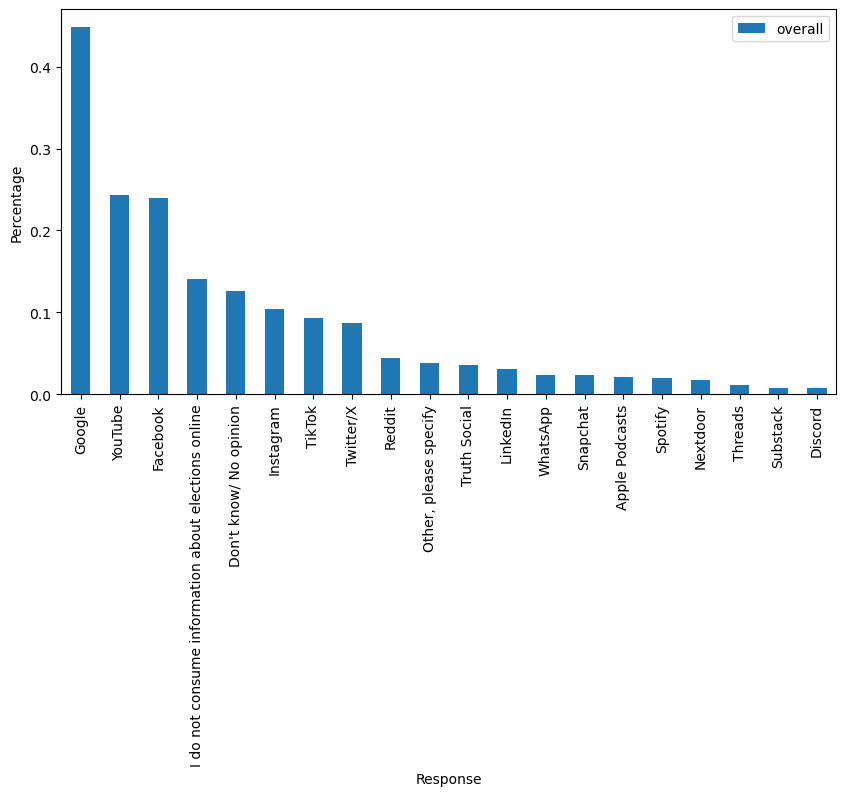

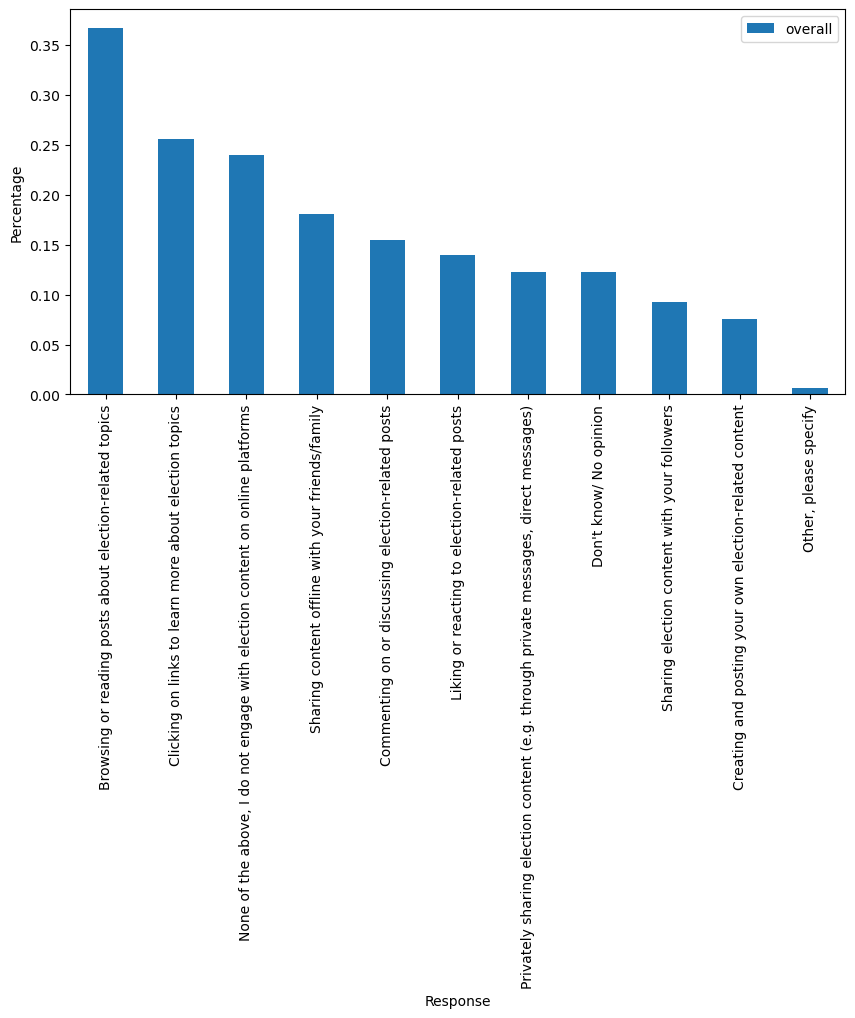

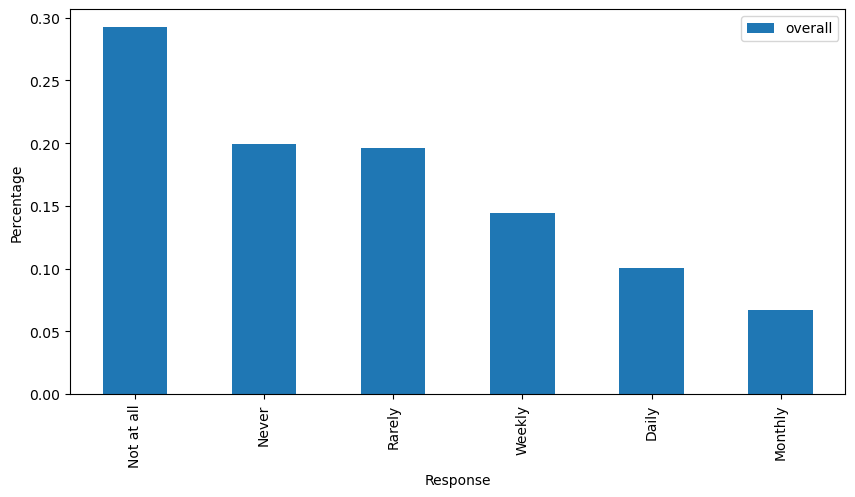

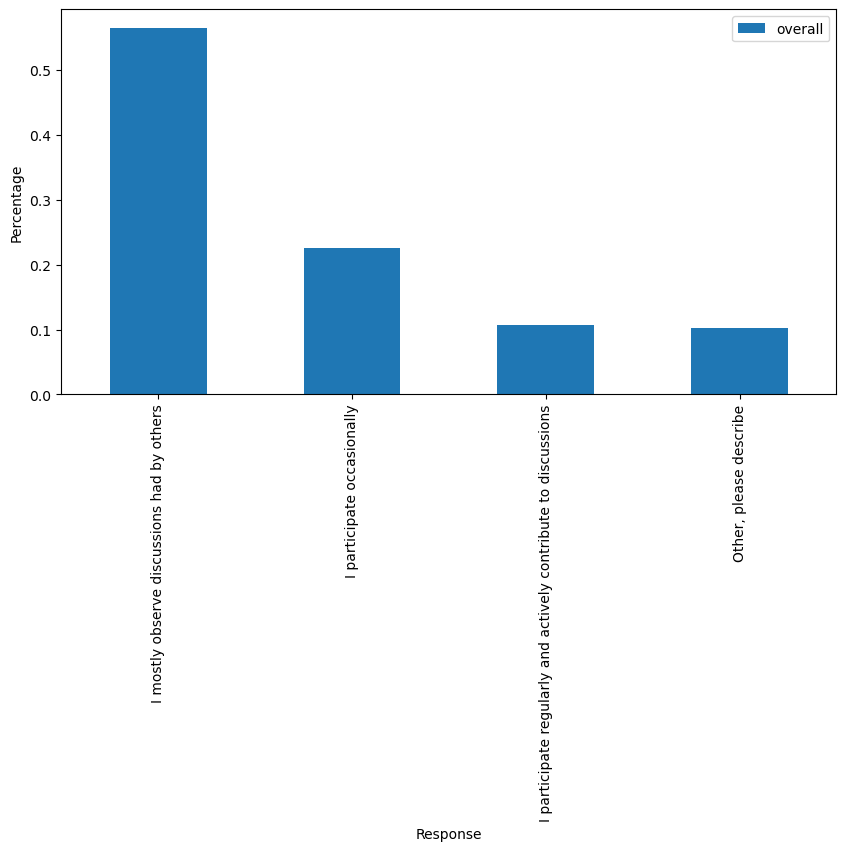

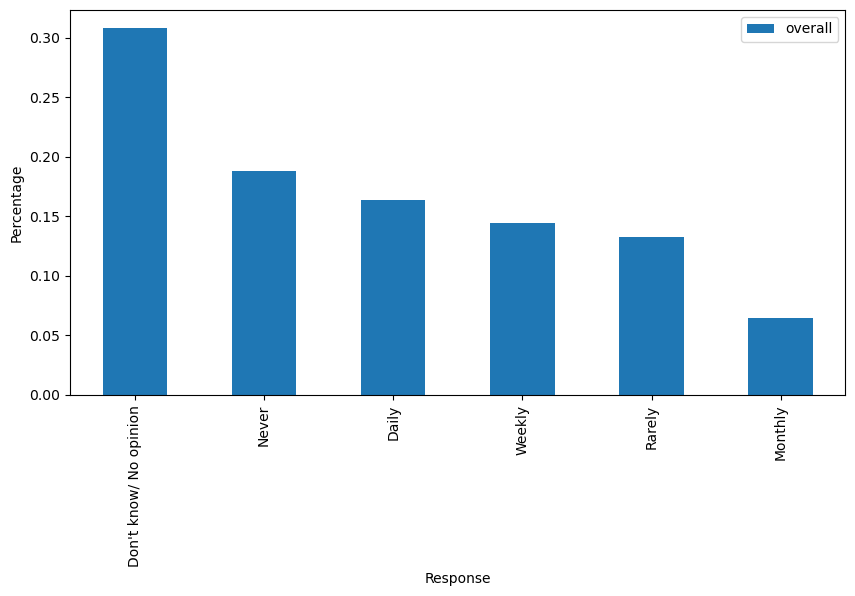

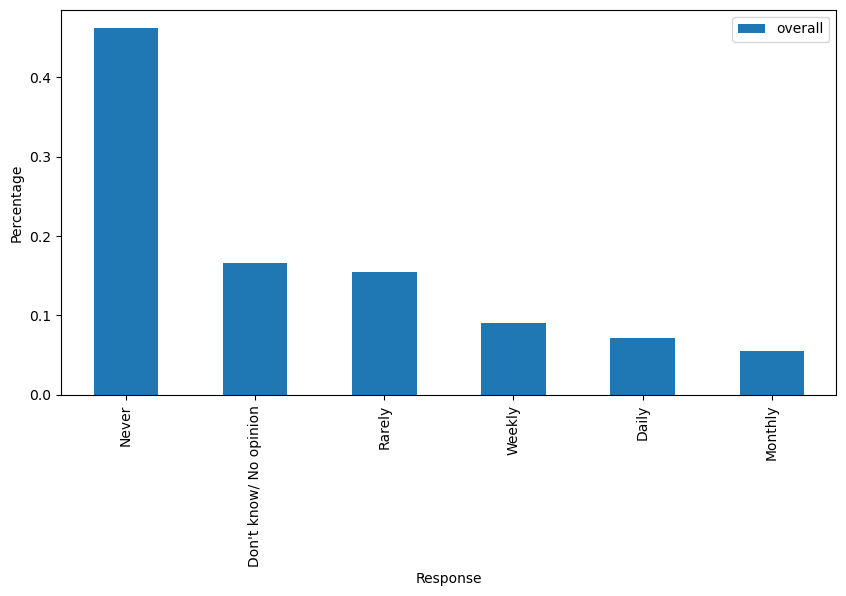

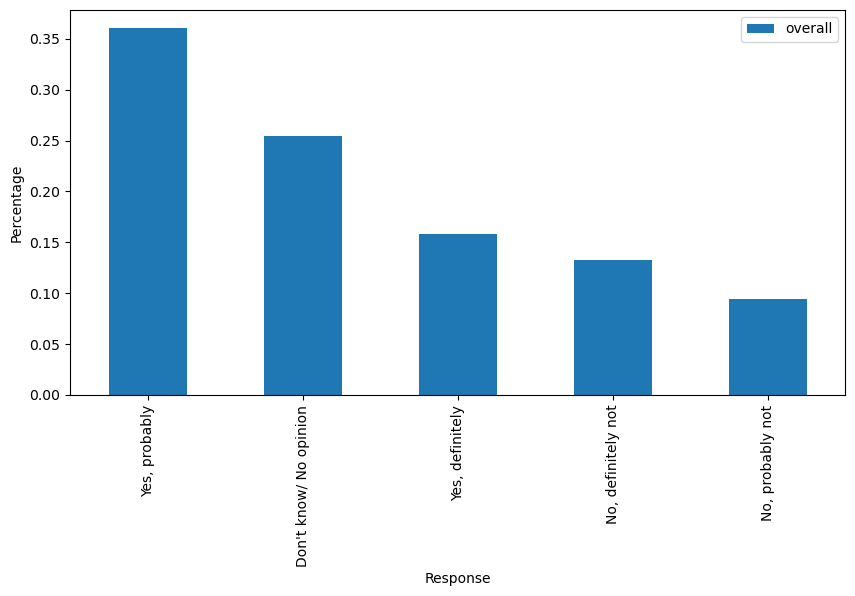

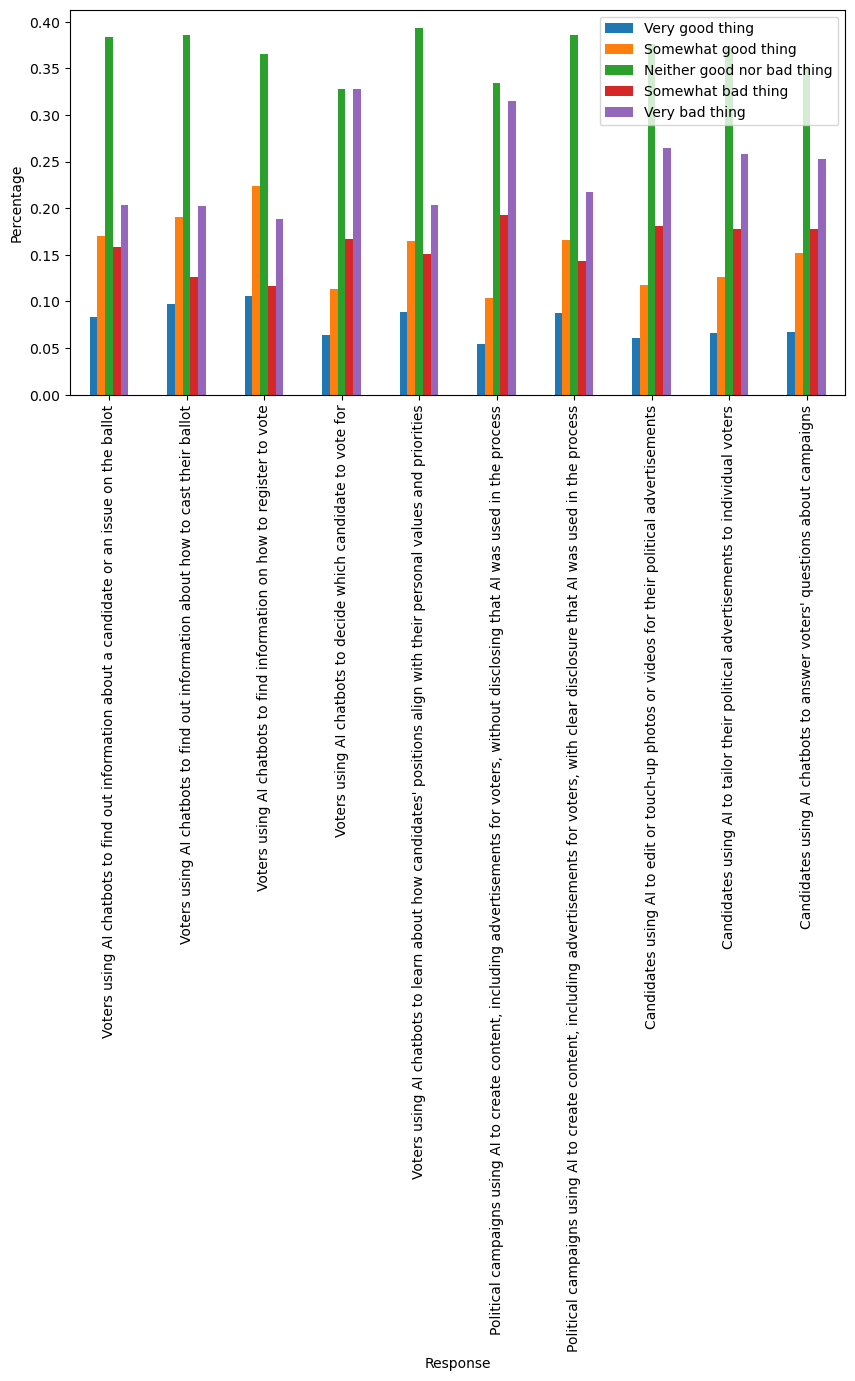

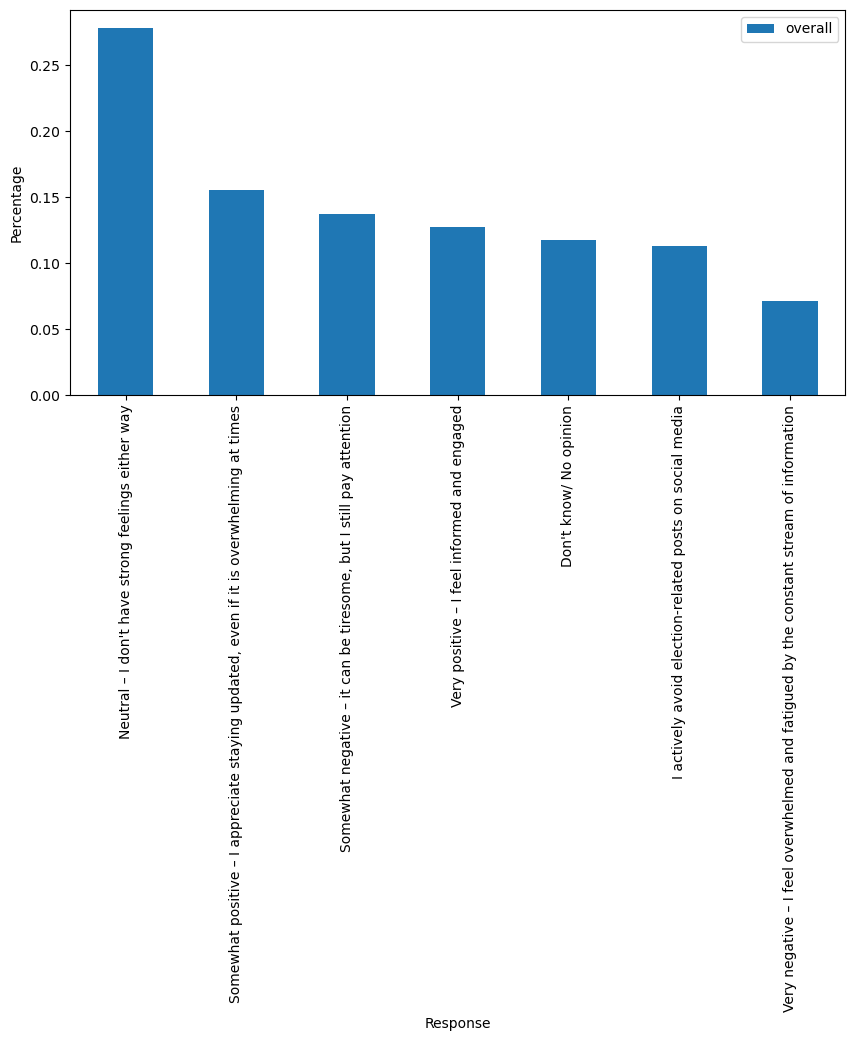

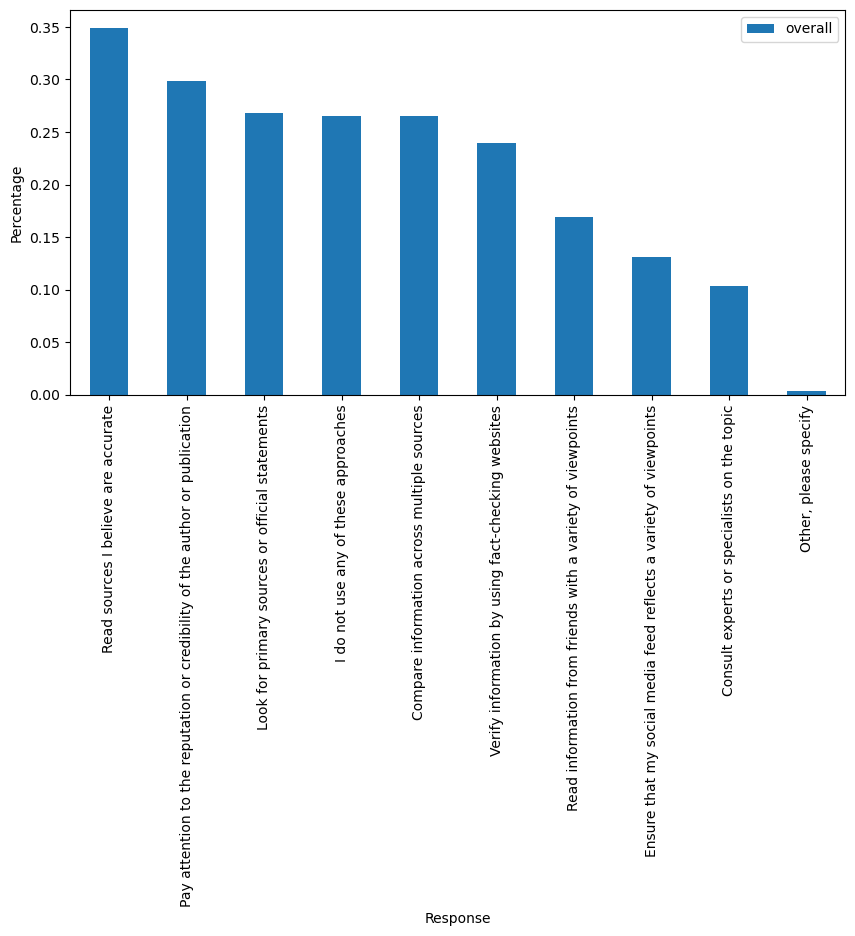

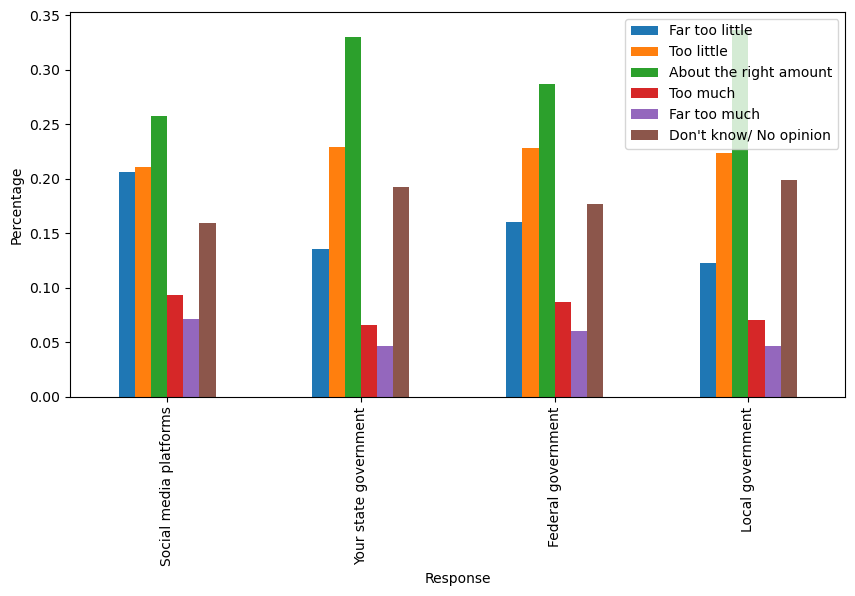

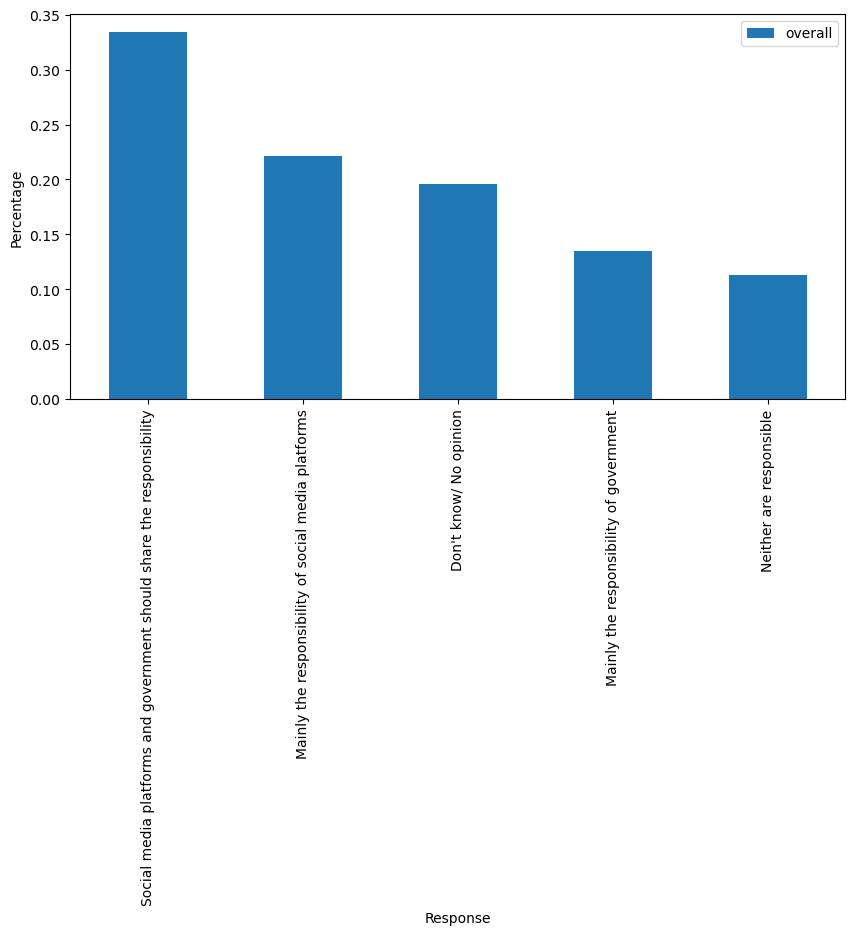

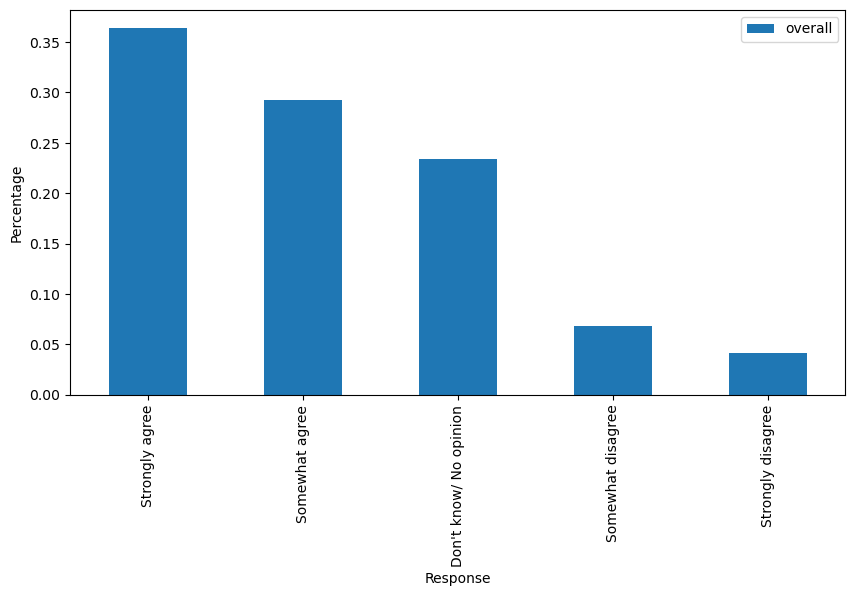

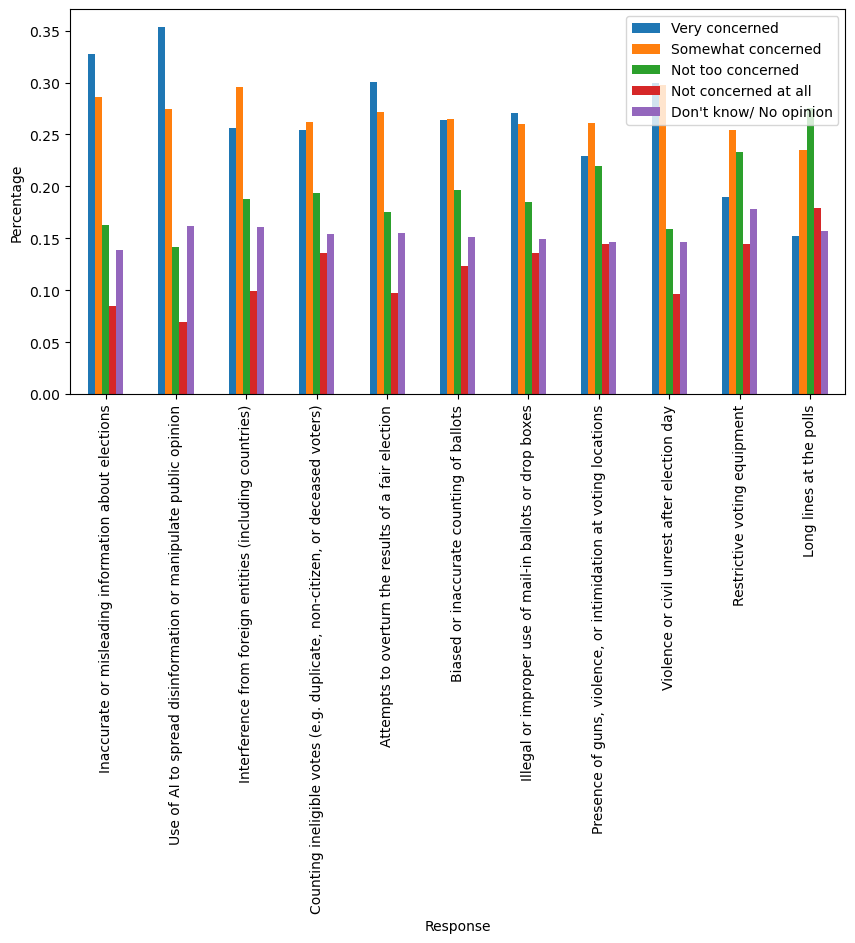

In [14]:
# TO ASK ALL QUESTIONS FOR 2024 (sub confidence)

demo = None
questions = []

for i in range(1,20):
    questions.append("BPC"+str(i))
questions.append("BPC24") #add last q following confidence

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)

     # df bar chart

Figuring out conjoint issue

In [9]:
# get columsn in data that start iwth "BPC6"
data[data.filter(regex='^BPC6').columns]

,BPC6_1NET,BPC6_2NET,BPC6_3NET,BPC6_4NET,BPC6_5NET,BPC6_6NET,BPC6_7NET,BPC6_8NET,BPC6_9NET,BPC6_10NET,BPC6_11NET,BPC6_12NET,BPC6_13NET,BPC6_14NET,BPC6_15NET,BPC6_16NET,BPC6_17NET,BPC6_18NET,BPC6_19NET,BPC6_20NET
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2
2200,2,1,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
2201,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2
2202,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2


In [10]:
def data_type_check(data,q_columns):
    """
    returns boolean value indicating question type
    """
    matrix = False
    multiple_selections = False

    if len(q_columns) == 0: # underscore only used when each option has selections
        return multiple_selections, matrix # single selection

    ## to address single select questions with a short response text answer
    elif (len(q_columns) == 1) and ("TEXT" in q_columns[0]):
        return multiple_selections, matrix # single selection

    ## selects matrix quetsion (if BOTH multiple columns per question and multiple response categories within each column)
    elif (len(q_columns) > 1) and (len(data[[q_columns[0]]].dropna()[q_columns[0]].unique()) > 2):
        matrix = True
        return multiple_selections, matrix

    ## otherwise, probably mulitple selections
    else:
        multiple_selections = True
        return multiple_selections, matrix

In [11]:
q_columns = data.filter(regex='^'+question+"_").columns

data_type_check(data,q_columns)

data.filter(regex='^' + question + r'[a-z]$').columns

Index([], dtype='object')